In this notebook I will be exloring the use of the Armina model on 10 random stocks in the S&P dataset 

In [1]:
import os 
os.chdir('/Users/marcs')

In [2]:
import matplotlib.pyplot as plt
from pickle_loader import pickle_loader
import datetime as dt
import pandas as pd
from random import seed
from random import randint
import numpy as np
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

In [3]:
technical_data = pickle_loader('/Users/marcs/OneDrive/Documents/stock_analysis2/technical_us.pickle')                        

In [4]:
seed(99)
random_numbers = [randint(0, len(technical_data) - 1) for _ in range(10)]
random_numbers

[206, 194, 102, 306, 91, 117, 127, 68, 389, 44]

In [5]:
tickers = list(technical_data.keys())
exploratory_tickers = [tickers[random_number] for random_number in random_numbers]

In [6]:
exploratory_data = [technical_data[exploratory_ticker] for exploratory_ticker in exploratory_tickers]

In [7]:
exploratory_data[0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-09-30 00:00:00-04:00,12.628805,12.681942,12.478252,12.540244,78820500,0.0,0.0
2021-10-01 00:00:00-04:00,12.628805,12.726222,12.407403,12.540244,51880900,0.0,0.0
2021-10-04 00:00:00-04:00,12.637664,13.098181,12.593383,12.708512,78332500,0.0,0.0
2021-10-05 00:00:00-04:00,12.788216,12.788216,12.495964,12.655375,55915800,0.0,0.0
2021-10-06 00:00:00-04:00,12.522533,12.699655,12.301131,12.504821,61020300,0.0,0.0
...,...,...,...,...,...,...,...
2023-09-25 00:00:00-04:00,12.350000,12.700000,12.340000,12.580000,41219400,0.0,0.0
2023-09-26 00:00:00-04:00,12.490000,12.660000,12.370000,12.430000,41261000,0.0,0.0
2023-09-27 00:00:00-04:00,12.520000,12.520000,12.250000,12.390000,41616600,0.0,0.0


The close price is the price that is being modeled/pricted

The start of the train dataset is '2021-09-30 00:00:00-0400'.

The end of the train set is '2022-09-27 00:00:00-0400' .

In [8]:
train_set = [exploratory_data[i].loc['2021-09-30 00:00:00-0400':'2022-09-27 00:00:00-0400']['Close'].to_numpy() for i in range(len(exploratory_data))]

In [9]:
train_set[0].size

250

The date we are trying to pridict is 2022-12-27

In [10]:
exploratory_data[1].loc['2022-12-27 00:00:00-05:00']['Close']


392.8230895996094

In [11]:
test_set = [exploratory_data[i].loc['2022-12-27 00:00:00-0500']['Close'] for i in range(len(exploratory_data))]

In [12]:
test_set

[10.29378890991211,
 392.8230895996094,
 86.24337005615234,
 344.0606994628906,
 7.670000076293945,
 164.76705932617188,
 229.92918395996094,
 81.96320343017578,
 274.18048095703125,
 129.4775848388672]

#### Try different amounts of smoothing

I will smooth by taking the average over a given time period. The time periods I will use are 1 day (no smoothing), 1 week, 1 month and 3 months.

In [36]:
def get_smoothing_data(len_smoothing_period, train_set , num_day_train_set):
    smoothing_data = []
    
    for stock_data in train_set:
        len_stock_set = stock_data.size
        factor_missing_days = len_stock_set / num_day_train_set # factor which captures the ratio of missing days in the total number of days in the train set
        adjusted_smoothing_period = int(np.round(len_smoothing_period * factor_missing_days)) # smoothing period ajusted for the missing days 
        remainder = len_stock_set % adjusted_smoothing_period
        len_start_period = adjusted_smoothing_period + remainder
        
        first_value = np.mean(stock_data[:len_start_period])
        other_values = np.mean(stock_data[len_start_period:].reshape(-1, adjusted_smoothing_period), axis = 1)
        
        smoothing_data.append(np.insert(other_values, 0, first_value))
        
    return smoothing_data

In [14]:
no_smoothing = train_set
weekly_smoothing = get_smoothing_data(len_smoothing_period = 7, train_set = train_set , num_day_train_set = 365)
monthly_smoothing = get_smoothing_data(len_smoothing_period = 30, train_set = train_set , num_day_train_set = 365)
quarterly_smoothing = get_smoothing_data(len_smoothing_period = int(365/4), train_set = train_set , num_day_train_set = 365)

In [15]:
test_set

[10.29378890991211,
 392.8230895996094,
 86.24337005615234,
 344.0606994628906,
 7.670000076293945,
 164.76705932617188,
 229.92918395996094,
 81.96320343017578,
 274.18048095703125,
 129.4775848388672]

In [16]:
monthly_smoothing[2]

array([ 59.00927124,  61.26657377,  66.88681412,  71.6124907 ,
        92.31056795, 100.26695433,  96.95335715,  88.55159069,
        84.34182485, 101.32600367,  99.79294259])

### Estimate the diffrencing terms 
Use the KPSS and ADF tests to estimate the differencing terms for each level of smoothing 

In [17]:
all_smoothing_data = [no_smoothing, weekly_smoothing, monthly_smoothing, quarterly_smoothing]
all_smoothing_titles = ['no_smoothing', 'weekly_smoothing', 'monthly_smoothing', 'quarterly_smoothing']

In [18]:
from pmdarima.arima import ndiffs

for i, data in enumerate(all_smoothing_data[:3]):
    print('*****' + all_smoothing_titles[i] + '*****')
    for stock in data:
        kpss_diffs = ndiffs(stock, alpha=0.05, test='kpss', max_d=4)
        adf_diffs = ndiffs(stock, alpha=0.05, test='adf', max_d=4)
        n_diffs = max(adf_diffs, kpss_diffs)
        print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

*****no_smoothing*****
Estimated differencing term: 1
Estimated differencing term: 1
Estimated differencing term: 1
Estimated differencing term: 1
Estimated differencing term: 1
Estimated differencing term: 1
Estimated differencing term: 1
Estimated differencing term: 1
Estimated differencing term: 1
Estimated differencing term: 1
*****weekly_smoothing*****
Estimated differencing term: 2
Estimated differencing term: 2
Estimated differencing term: 2
Estimated differencing term: 1
Estimated differencing term: 1
Estimated differencing term: 2
Estimated differencing term: 2
Estimated differencing term: 1
Estimated differencing term: 2
Estimated differencing term: 2
*****monthly_smoothing*****
Estimated differencing term: 2
Estimated differencing term: 2
Estimated differencing term: 1
Estimated differencing term: 0
Estimated differencing term: 3
Estimated differencing term: 4
Estimated differencing term: 2
Estimated differencing term: 1
Estimated differencing term: 4
Estimated differencing 

There seems to be an increase in the optimal d as the periods of averging get larger. However this also comes with an increase in variation. This could be due to the fact that the size of the dateset for each stock gets smaller as the period of smoothing increases, which leads to a inacurate determination of the optimal value of d. Furthermore the averaging provides the same goal as diffrencing which is smoothing. Taking these two factors in consideration I will opt to fix the differencing term at 1.

#### Fitting the ARMINA model 

In [19]:
trained_models = {}

for i, data in enumerate(all_smoothing_data):
    print('*****' + all_smoothing_titles[i] + '*****')
    trained_models[all_smoothing_titles[i]] = []
    for stock_data in data:
        trained_models[all_smoothing_titles[i]].append(\
        pm.auto_arima(stock_data, d=1, seasonal=False, stepwise=True,\
            suppress_warnings=True, error_action="ignore", max_p=6,\
            max_order=None, trace=False))



*****no_smoothing*****
*****weekly_smoothing*****
*****monthly_smoothing*****
*****quarterly_smoothing*****


In [20]:
trained_models

{'no_smoothing': [ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True),
  ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
        with_intercept=False),
  ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
        with_intercept=False)],
 'weekly_smoothing': [ARIMA(order=(0, 1, 1)

In [21]:
# Find the number of periods to forcast the stock price between 2022-09-27 and 2022-12-27 
from datetime import date

d0 = date(2022, 9, 27)
d1 = date(2022, 12, 27)
delta = d1 - d0
print(delta.days)

daily_period = delta.days
weekly_period = int(np.round(delta.days/7))
monthly_period = int(np.round(delta.days/30))
quaterly_period = 1

all_periods = [daily_period, weekly_period, monthly_period, quaterly_period]

91


In [22]:
def forecast_n_steps(n):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])


all_predictions = {}
i = 0
for k, models in trained_models.items():
    print('*** ' + k + ' ***')
    all_predictions[k] = []
    for model in models:
        all_predictions[k].append(forecast_n_steps(all_periods[i]))
    i += 1
    
print(all_predictions)

*** no_smoothing ***
*** weekly_smoothing ***
*** monthly_smoothing ***
*** quarterly_smoothing ***
{'no_smoothing': [(10.83310317993164, [9.906231782584186, 11.759974577279095]), (387.66937255859375, [374.3016119550061, 401.0371331621814]), (94.01812744140625, [88.96665344148434, 99.06960144132816]), (284.28399658203125, [269.9984807150695, 298.569512448993]), (9.231957854732425, [7.970264889610503, 10.493650819854347]), (167.742919921875, [161.4921202641543, 173.9937195795957]), (229.49566650390625, [223.32949660130265, 235.66183640650985]), (70.35098266601562, [65.6683276665744, 75.03363766545685]), (276.64817372525124, [267.00642135191794, 286.28992609858454]), (150.86502075195312, [144.77559473345386, 156.9544467704524])], 'weekly_smoothing': [(10.603706452972832, [8.95282966230736, 12.254583243638303]), (395.949462890625, [368.85273148378815, 423.04619429746185]), (94.78305206298828, [85.69871853433375, 103.8673855916428]), (292.34771118164065, [264.7070237247466, 319.98839863853

In [26]:
y_pred = {k:[pred[0] for pred in k_pred] for k, k_pred in all_predictions.items()}

MSE = {}
SMAPE = {}
for smoothing, predictions in y_pred.items():
    MSE[smoothing] = mean_squared_error(test_set, predictions)
    SMAPE[smoothing] = smape(test_set, predictions)
    
print(MSE)
print(SMAPE)

{'no_smoothing': 427.0391708308466, 'weekly_smoothing': 344.20506863945144, 'monthly_smoothing': 469.8250620160129, 'quarterly_smoothing': 445.12577352491746}
{'no_smoothing': 8.594192891427026, 'weekly_smoothing': 8.222827814185532, 'monthly_smoothing': 12.22963050314078, 'quarterly_smoothing': 14.268540266011001}


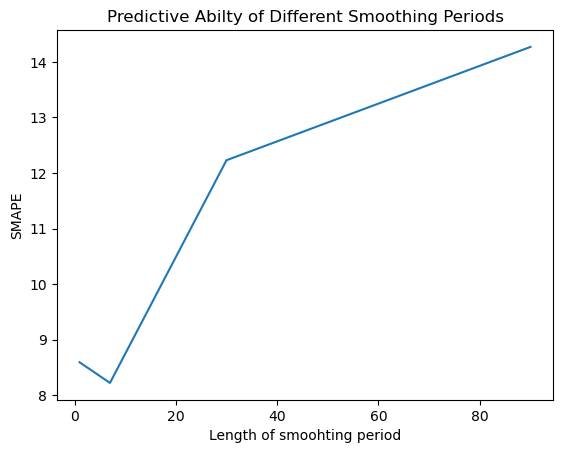

In [35]:
plt.plot([1, 7, 30, 90], SMAPE.values())
plt.ylabel('SMAPE')
plt.xlabel('Length of smoohting period')
plt.title('Predictive Abilty of Different Smoothing Periods')
plt.show()

The above table shows the SMAPE (https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.metrics.smape.html#pmdarima.metrics.smape) of diffrent smoothing periods. Smaller values of SMAPE can be interpreted as better predictive abilty. The week long smoothing period seems to show the best preformance followed by no smoothing. Monthly and quarterly smoothing show far worse performace than both weekly and daily smoohting.

This shows that smoothing over smaller periods can lead to higher predictive abilty using the auto armia models. A larger dataset however is needed to select the optimal number. 

In my next script ARMIA_smoothing selection. I will find the optimal smoohting period (which based of the above graph I estimate to be between [1-14 days]) for the entire stock dataset using the same train and test periods. 